✅ Kaggle Environment Check:
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB
        KAGGLE 2D TO 3D CONVERSION NOTEBOOK
📊 Performance Benchmark
------------------------------

Testing size: 256x256
Average inference time: 0.008 seconds
GPU Memory: 28.7 MB allocated, 354.0 MB reserved

Testing size: 512x512
Average inference time: 0.008 seconds
GPU Memory: 100.1 MB allocated, 354.0 MB reserved

Testing size: 1024x768
Average inference time: 0.009 seconds
GPU Memory: 286.3 MB allocated, 354.0 MB reserved

        STARTING MAIN PROCESSING
🚀 Starting 2D to 3D Conversion on Kaggle
--------------------------------------------------
✅ Model loaded on cuda
📁 Found 3 images in input folder

🔍 Processing image 1: table.jpg
✅ Visualization saved to /kaggle/working/result_1.png


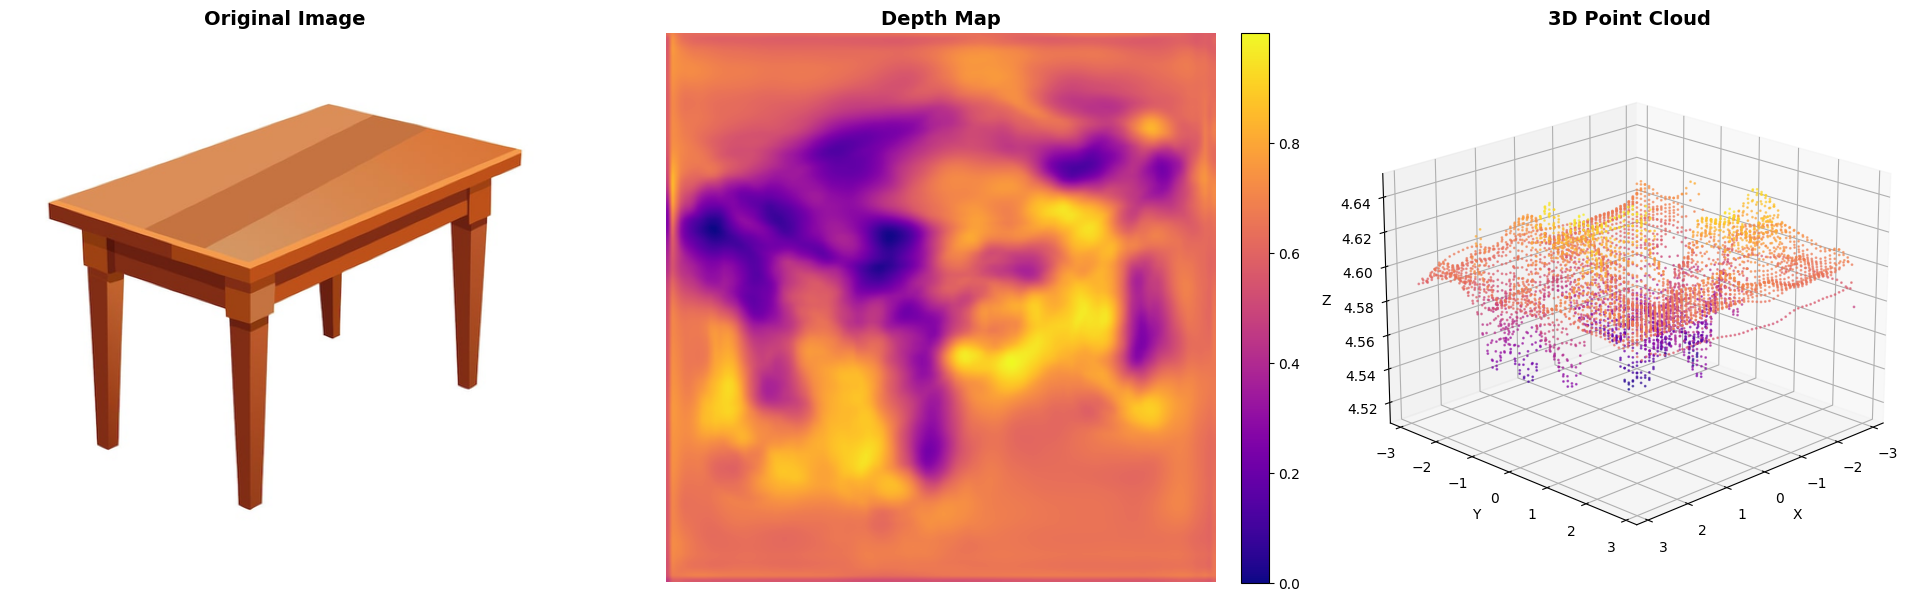

💾 Saved depth map: /kaggle/working/depth_1.png
💾 Saved point cloud: /kaggle/working/points_1.npy

🔍 Processing image 2: chair.jpg
✅ Visualization saved to /kaggle/working/result_2.png


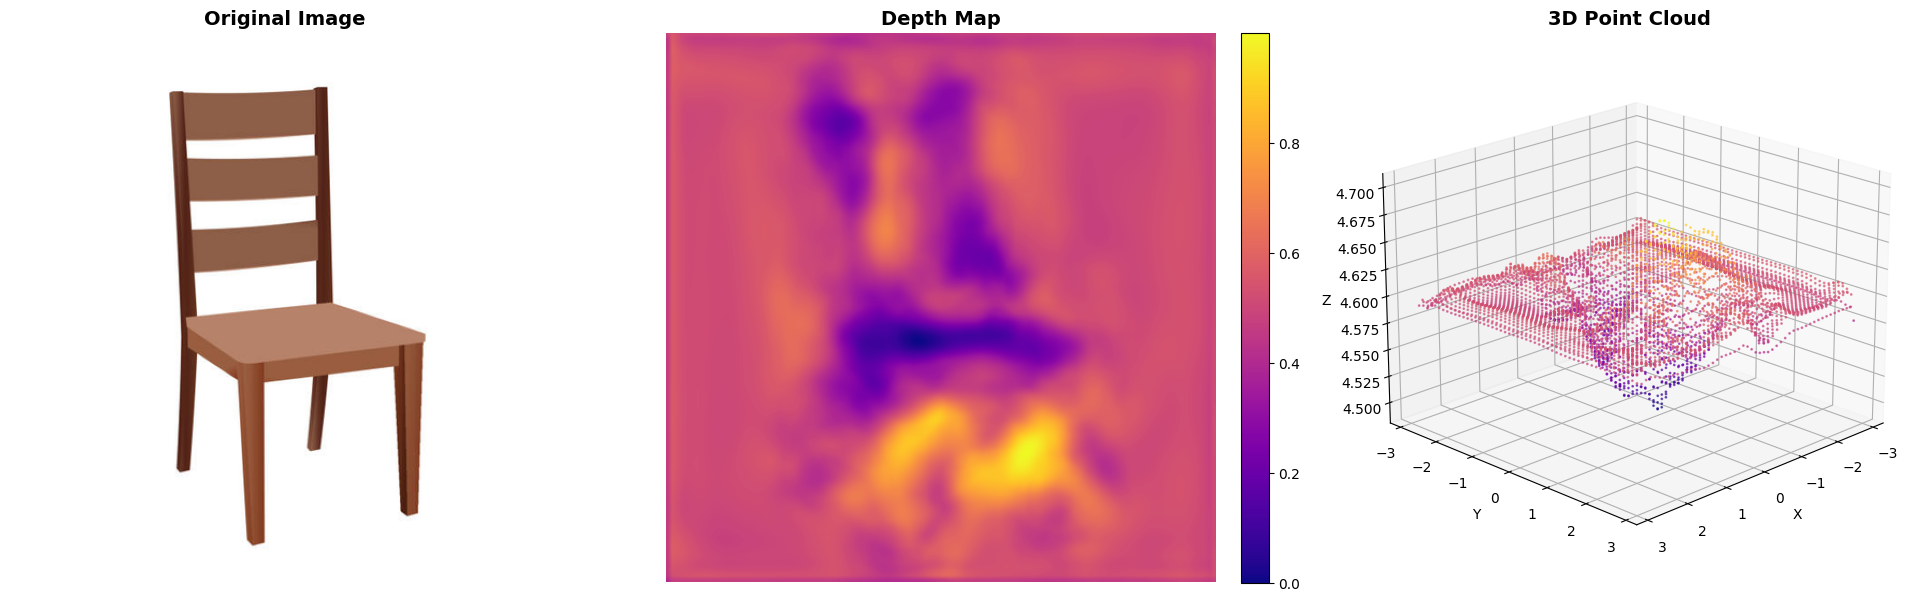

💾 Saved depth map: /kaggle/working/depth_2.png
💾 Saved point cloud: /kaggle/working/points_2.npy

🔍 Processing image 3: door.jpg
✅ Visualization saved to /kaggle/working/result_3.png


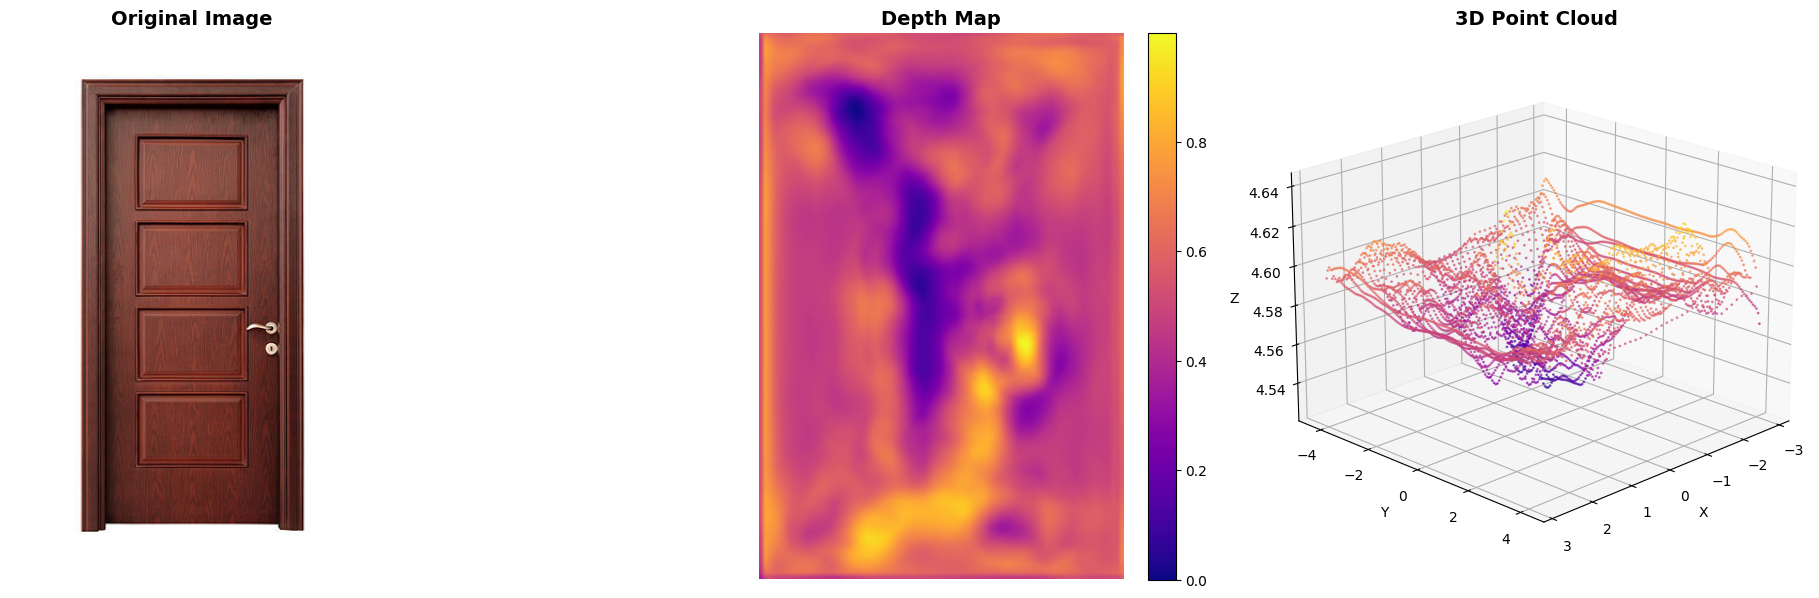

💾 Saved depth map: /kaggle/working/depth_3.png
💾 Saved point cloud: /kaggle/working/points_3.npy

✅ PROCESSING COMPLETE

Output files in /kaggle/working:
  📄 depth_3.png (58.2 KB)
  📄 result_2.png (704.6 KB)
  📄 sample_room.jpg (8.1 KB)
  📄 points_2.npy (248.8 KB)
  📄 points_3.npy (258.1 KB)
  📄 result_3.png (844.3 KB)
  📄 depth_1.png (73.2 KB)
  📄 points_1.npy (248.8 KB)
  📄 result_1.png (893.1 KB)
  📄 depth_2.png (63.9 KB)


In [2]:
# kaggle_2d_to_3d.ipynb - Kaggle Notebook
# Note: Kaggle has limited interactive capabilities

import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Kaggle Environment Check:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set up paths for Kaggle
INPUT_PATH = "/kaggle/input/my-image-dataset"
OUTPUT_PATH = "/kaggle/working"
MODEL_PATH = "/kaggle/working/models"

os.makedirs(MODEL_PATH, exist_ok=True)

# 1. LIGHTWEIGHT MODEL FOR KAGGLE (Memory Efficient)
class KaggleDepthModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use efficient MobileNetV3
        backbone = models.mobilenet_v3_small(pretrained=True).features
        self.encoder = nn.Sequential(*list(backbone.children()))
        
        # Simplified decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(576, 256, 1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

# 2. OPTIMIZED PROCESSING FOR KAGGLE
def process_image_kaggle(image_path, model, device='cuda'):
    """Optimized processing for Kaggle environment"""
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Resize for faster processing (Kaggle has memory limits)
    max_size = 512
    if max(original_size) > max_size:
        ratio = max_size / max(original_size)
        new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
        image = image.resize(new_size, Image.LANCZOS)
    
    # Transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        depth = model(input_tensor)
    
    # Resize to original
    depth = torch.nn.functional.interpolate(
        depth, 
        size=image.size[::-1], 
        mode='bilinear', 
        align_corners=False
    )
    
    depth_np = depth.squeeze().cpu().numpy()
    return image, depth_np

# 3. VISUALIZATION FOR KAGGLE NOTEBOOK
def visualize_kaggle_results(image, depth_map, points=None, save_path=None):
    """Create visualization suitable for Kaggle notebook"""
    
    fig = plt.figure(figsize=(20, 6))
    
    # Original image
    ax1 = fig.add_subplot(131)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Depth map
    ax2 = fig.add_subplot(132)
    depth_display = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8)
    im = ax2.imshow(depth_display, cmap='plasma')
    ax2.set_title('Depth Map', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    # 3D visualization (if points provided)
    if points is not None and len(points) > 1000:
        ax3 = fig.add_subplot(133, projection='3d')
        
        # Subsample points for faster rendering
        subsample = len(points) // 5000
        points_sub = points[::subsample]
        
        ax3.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                   c=points_sub[:, 2], cmap='plasma', s=1, alpha=0.6)
        ax3.set_title('3D Point Cloud', fontsize=14, fontweight='bold')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.view_init(elev=20, azim=45)
    else:
        ax3 = fig.add_subplot(133)
        ax3.text(0.5, 0.5, '3D Visualization\n(Points required)', 
                ha='center', va='center', fontsize=12)
        ax3.set_title('3D Point Cloud', fontsize=14, fontweight='bold')
        ax3.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Visualization saved to {save_path}")
    
    plt.show()

# 4. MAIN KAGGLE EXECUTION
def main_kaggle():
    print("🚀 Starting 2D to 3D Conversion on Kaggle")
    print("-" * 50)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = KaggleDepthModel().to(device)
    print(f"✅ Model loaded on {device}")
    
    # Check for input images
    sample_images = []
    for dirname, _, filenames in os.walk(INPUT_PATH):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                sample_images.append(os.path.join(dirname, filename))
    
    if sample_images:
        print(f"📁 Found {len(sample_images)} images in input folder")
        
        # Process first 3 images (Kaggle memory limits)
        for i, img_path in enumerate(sample_images[:3]):
            print(f"\n🔍 Processing image {i+1}: {os.path.basename(img_path)}")
            
            try:
                # Process image
                image, depth_map = process_image_kaggle(img_path, model, device)
                
                # Create point cloud (simplified for Kaggle)
                h, w = depth_map.shape
                
                # Create grid (subsampled for performance)
                step = max(1, int(np.sqrt(h * w / 10000)))
                y_coords, x_coords = np.meshgrid(
                    np.arange(0, h, step), 
                    np.arange(0, w, step), 
                    indexing='ij'
                )
                
                # Convert to 3D
                depth_sampled = depth_map[::step, ::step]
                focal = w * 0.8
                cx, cy = w/2, h/2
                
                z = depth_sampled.flatten() * 10
                x = (x_coords.flatten() - cx) * z / focal
                y = (y_coords.flatten() - cy) * z / focal
                
                points = np.stack([x, y, z], axis=-1)
                
                # Visualize
                output_path = f"/kaggle/working/result_{i+1}.png"
                visualize_kaggle_results(image, depth_map, points, output_path)
                
                # Save depth map
                depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
                depth_uint8 = (depth_normalized * 255).astype(np.uint8)
                cv2.imwrite(f"/kaggle/working/depth_{i+1}.png", depth_uint8)
                print(f"💾 Saved depth map: /kaggle/working/depth_{i+1}.png")
                
                # Save points as numpy array
                np.save(f"/kaggle/working/points_{i+1}.npy", points)
                print(f"💾 Saved point cloud: /kaggle/working/points_{i+1}.npy")
                
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
    
    else:
        print("📸 No images found in input folder. Creating sample...")
        
        # Create sample image
        from PIL import Image, ImageDraw
        img = Image.new('RGB', (512, 512), color='lightblue')
        draw = ImageDraw.Draw(img)
        
        # Draw a simple room
        draw.rectangle([(50, 400), (462, 462)], fill='brown')  # Floor
        draw.rectangle([(100, 300), (250, 380)], fill='blue')   # Bed
        draw.rectangle([(300, 320), (400, 360)], fill='brown')  # Table
        draw.rectangle([(350, 100), (450, 200)], fill='white')  # Window
        
        # Save sample
        sample_path = "/kaggle/working/sample_room.jpg"
        img.save(sample_path)
        
        # Process the sample
        image, depth_map = process_image_kaggle(sample_path, model, device)
        visualize_kaggle_results(image, depth_map)
        
        print("✅ Created and processed sample image")

# 5. KAGGLE-SPECIFIC UTILITIES
def kaggle_benchmark():
    """Benchmark performance on Kaggle"""
    import time
    
    print("📊 Performance Benchmark")
    print("-" * 30)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = KaggleDepthModel().to(device)
    
    # Test different image sizes
    test_sizes = [(256, 256), (512, 512), (1024, 768)]
    
    for size in test_sizes:
        print(f"\nTesting size: {size[0]}x{size[1]}")
        
        # Create dummy image
        dummy_image = torch.randn(1, 3, *size).to(device)
        
        # Warmup
        for _ in range(3):
            _ = model(dummy_image)
        
        # Benchmark
        torch.cuda.synchronize()
        start_time = time.time()
        
        for _ in range(10):
            _ = model(dummy_image)
        
        torch.cuda.synchronize()
        end_time = time.time()
        
        avg_time = (end_time - start_time) / 10
        print(f"Average inference time: {avg_time:.3f} seconds")
        
        # Memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated() / 1024**2
            memory_reserved = torch.cuda.memory_reserved() / 1024**2
            print(f"GPU Memory: {memory_allocated:.1f} MB allocated, {memory_reserved:.1f} MB reserved")

# 6. EXECUTE IN KAGGLE
if __name__ == "__main__":
    print("=" * 60)
    print("        KAGGLE 2D TO 3D CONVERSION NOTEBOOK")
    print("=" * 60)
    
    # Run benchmark
    kaggle_benchmark()
    
    print("\n" + "=" * 60)
    print("        STARTING MAIN PROCESSING")
    print("=" * 60)
    
    # Run main processing
    main_kaggle()
    
    print("\n" + "=" * 60)
    print("✅ PROCESSING COMPLETE")
    print("=" * 60)
    print("\nOutput files in /kaggle/working:")
    
    # List output files
    for file in os.listdir("/kaggle/working"):
        if file.endswith(('.png', '.npy', '.jpg')):
            size = os.path.getsize(f"/kaggle/working/{file}") / 1024
            print(f"  📄 {file} ({size:.1f} KB)")

In [4]:
# Cell 1: Install Required Packages
print("📦 Installing required packages...")

# Try to install all packages
!pip install open3d plotly trimesh scikit-image pyntcloud -q
!pip install potpourri3d vedo -q  # Alternative 3D libraries

print("✅ Packages installed successfully!")

# Check what's available
import sys
import pkg_resources

required_packages = ['numpy', 'PIL', 'matplotlib', 'plotly', 'cv2', 'scipy']
available = []
missing = []

for package in required_packages:
    try:
        dist = pkg_resources.get_distribution(package.split('==')[0])
        available.append(f"{dist.key}=={dist.version}")
    except:
        missing.append(package)

print(f"\n📊 Available packages: {len(available)}")
print(f"⚠️  Missing packages: {len(missing)}")
if missing:
    print(f"Missing: {missing}")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 112.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 2.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.5 MB/s eta 0:00:0000:01
✅ Packages installed successfully!

📊 Available packages: 4
⚠️  Missing packages: 2
Missing: ['PIL', 'cv2']


In [5]:
# Cell 2: Import with Fallbacks
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

print("🔧 Importing main libraries...")

# Try to import open3d, with fallback
try:
    import open3d as o3d
    print(f"✅ Open3D {o3d.__version__} loaded successfully")
    HAS_OPEN3D = True
except ImportError as e:
    print(f"⚠️  Open3D not available: {e}")
    print("🔄 Using alternative 3D visualization methods...")
    HAS_OPEN3D = False

# Try to import plotly
try:
    import plotly.graph_objects as go
    import plotly.express as px
    HAS_PLOTLY = True
    print("✅ Plotly loaded successfully")
except:
    HAS_PLOTLY = False
    print("⚠️  Plotly not available")

# Try to import trimesh
try:
    import trimesh
    HAS_TRIMESH = True
    print("✅ Trimesh loaded successfully")
except:
    HAS_TRIMESH = False
    print("⚠️  Trimesh not available")

# Try to import skimage
try:
    from skimage import measure
    HAS_SKIMAGE = True
    print("✅ scikit-image loaded successfully")
except:
    HAS_SKIMAGE = False
    print("⚠️  scikit-image not available")

print("\n" + "="*60)
print(f"3D Capabilities Summary:")
print(f"• Open3D: {'✅' if HAS_OPEN3D else '❌'}")
print(f"• Plotly: {'✅' if HAS_PLOTLY else '❌'}")
print(f"• Trimesh: {'✅' if HAS_TRIMESH else '❌'}")
print(f"• Scikit-image: {'✅' if HAS_SKIMAGE else '❌'}")
print("="*60)

🔧 Importing main libraries...
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ Open3D 0.19.0 loaded successfully
✅ Plotly loaded successfully
✅ Trimesh loaded successfully
✅ scikit-image loaded successfully

3D Capabilities Summary:
• Open3D: ✅
• Plotly: ✅
• Trimesh: ✅
• Scikit-image: ✅


In [6]:
# Cell 3: ALTERNATIVE 3D RECONSTRUCTION WITHOUT OPEN3D
print("🔄 Setting up alternative 3D reconstruction pipeline...")

class Simple3DReconstructor:
    """3D reconstruction using only basic libraries"""
    
    def __init__(self):
        self.has_open3d = HAS_OPEN3D
        self.has_plotly = HAS_PLOTLY
        self.has_trimesh = HAS_TRIMESH
        
    def create_depth_map(self, image_array):
        """Generate synthetic depth map"""
        h, w = image_array.shape[:2]
        
        # Create coordinate grids
        y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        
        # Center-based depth
        center_x, center_y = w // 2, h // 2
        dist = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
        
        # Normalize to 0-1 range
        depth = 1.0 - (dist / np.sqrt(center_x**2 + center_y**2))
        depth = np.clip(depth, 0.1, 1.0)
        
        # Add some structure (floor, walls)
        floor_mask = y_coords > h * 0.7
        depth[floor_mask] *= 0.8
        
        # Smooth
        depth = cv2.GaussianBlur(depth, (7, 7), 1.5)
        
        return depth
    
    def depth_to_pointcloud(self, depth_map, image_array, num_points=20000):
        """Convert depth map to 3D point cloud"""
        h, w = depth_map.shape
        
        # Subsample for performance
        step = max(1, int(np.sqrt(h * w / num_points)))
        y_coords, x_coords = np.meshgrid(
            np.arange(0, h, step),
            np.arange(0, w, step),
            indexing='ij'
        )
        
        depth_sampled = depth_map[::step, ::step]
        colors_sampled = image_array[::step, ::step]
        
        # Perspective projection
        focal = w * 0.8
        cx, cy = w/2, h/2
        
        z = depth_sampled.flatten() * 10
        x = (x_coords.flatten() - cx) * z / focal
        y = (y_coords.flatten() - cy) * z / focal
        colors = colors_sampled.reshape(-1, 3) / 255.0
        
        points = np.stack([x, y, z], axis=-1)
        
        return points, colors
    
    def create_mesh_from_points(self, points, colors, method='alpha_shape'):
        """Create mesh from point cloud using different methods"""
        
        if not self.has_trimesh and not self.has_open3d:
            print("⚠️  No mesh library available. Returning point cloud only.")
            return None, points, colors
        
        if self.has_open3d:
            # Use Open3D if available
            return self._create_mesh_open3d(points, colors)
        elif self.has_trimesh:
            # Use Trimesh if available
            return self._create_mesh_trimesh(points, colors, method)
        
        return None, points, colors
    
    def _create_mesh_open3d(self, points, colors):
        """Create mesh using Open3D"""
        import open3d as o3d
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
        # Estimate normals
        pcd.estimate_normals()
        
        # Create mesh using ball pivoting
        distances = pcd.compute_nearest_neighbor_distance()
        avg_dist = np.mean(distances)
        radius = 3 * avg_dist
        
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            pcd,
            o3d.utility.DoubleVector([radius, radius * 2])
        )
        
        return mesh, points, colors
    
    def _create_mesh_trimesh(self, points, colors, method='alpha_shape'):
        """Create mesh using Trimesh"""
        import trimesh
        
        if method == 'convex_hull':
            # Simple convex hull
            mesh = trimesh.convex.convex_hull(trimesh.points.PointCloud(points))
        else:
            # Try to create a surface (simplified)
            # This is a fallback - for better results, install open3d
            from scipy.spatial import Delaunay
            
            # Project to 2D for triangulation (simplified approach)
            points_2d = points[:, :2]
            tri = Delaunay(points_2d)
            
            # Create mesh from 2D triangulation
            vertices = points
            faces = tri.simplices
            
            mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        
        return mesh, points, colors
    
    def visualize_3d_matplotlib(self, points, colors, title="3D Point Cloud"):
        """Visualize using matplotlib (always available)"""
        fig = plt.figure(figsize=(15, 10))
        
        # 3D Point Cloud
        ax1 = fig.add_subplot(221, projection='3d')
        scatter = ax1.scatter(points[:, 0], points[:, 1], points[:, 2],
                             c=colors, s=1, alpha=0.6)
        ax1.set_title(f'{title} - Isometric View')
        ax1.view_init(elev=30, azim=45)
        
        # Top View
        ax2 = fig.add_subplot(222, projection='3d')
        ax2.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=points[:, 2], cmap='plasma', s=1, alpha=0.6)
        ax2.set_title('Top View')
        ax2.view_init(elev=90, azim=0)
        
        # Front View
        ax3 = fig.add_subplot(223, projection='3d')
        ax3.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=points[:, 1], cmap='Spectral', s=1, alpha=0.6)
        ax3.set_title('Front View')
        ax3.view_init(elev=0, azim=0)
        
        # Side View
        ax4 = fig.add_subplot(224, projection='3d')
        ax4.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=points[:, 0], cmap='viridis', s=1, alpha=0.6)
        ax4.set_title('Side View')
        ax4.view_init(elev=0, azim=90)
        
        plt.suptitle('Multi-view 3D Visualization', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def visualize_3d_plotly(self, points, colors, title="3D Point Cloud"):
        """Visualize using Plotly (interactive)"""
        if not HAS_PLOTLY:
            print("⚠️  Plotly not available. Using matplotlib instead.")
            return self.visualize_3d_matplotlib(points, colors, title)
        
        import plotly.graph_objects as go
        
        # Create interactive 3D scatter plot
        fig = go.Figure(data=[
            go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=[f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' 
                          for r, g, b in colors],
                    opacity=0.8
                ),
                name='Point Cloud'
            )
        ])
        
        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='data',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            height=700,
            margin=dict(l=0, r=0, b=0, t=40)
        )
        
        # Add multiple camera views as annotations
        camera_views = [
            dict(name="Isometric", eye=dict(x=1.5, y=1.5, z=1.5)),
            dict(name="Top", eye=dict(x=0, y=0, z=2)),
            dict(name="Front", eye=dict(x=2, y=0, z=0)),
            dict(name="Side", eye=dict(x=0, y=2, z=0))
        ]
        
        buttons = []
        for i, view in enumerate(camera_views):
            buttons.append(
                dict(
                    label=view['name'],
                    method='update',
                    args=[{'scene.camera.eye': view['eye']}]
                )
            )
        
        fig.update_layout(
            updatemenus=[{
                'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top'
            }]
        )
        
        fig.show()
        return fig
    
    def save_pointcloud(self, points, colors, filename="pointcloud.ply"):
        """Save point cloud to PLY format (no external libraries needed)"""
        with open(filename, 'w') as f:
            f.write("ply\n")
            f.write("format ascii 1.0\n")
            f.write(f"element vertex {len(points)}\n")
            f.write("property float x\n")
            f.write("property float y\n")
            f.write("property float z\n")
            f.write("property uchar red\n")
            f.write("property uchar green\n")
            f.write("property uchar blue\n")
            f.write("end_header\n")
            
            for i in range(len(points)):
                x, y, z = points[i]
                r, g, b = colors[i] * 255
                f.write(f"{x:.6f} {y:.6f} {z:.6f} ")
                f.write(f"{int(r)} {int(g)} {int(b)}\n")
        
        print(f"✅ Point cloud saved as {filename}")
        return filename
    
    def save_mesh(self, mesh, filename="mesh.obj"):
        """Save mesh to OBJ format"""
        if mesh is None:
            print("⚠️  No mesh to save")
            return None
        
        if HAS_TRIMESH and isinstance(mesh, trimesh.Trimesh):
            mesh.export(filename)
            print(f"✅ Mesh saved as {filename} (using Trimesh)")
            return filename
        elif HAS_OPEN3D:
            import open3d as o3d
            o3d.io.write_triangle_mesh(filename, mesh)
            print(f"✅ Mesh saved as {filename} (using Open3D)")
            return filename
        else:
            print("⚠️  Cannot save mesh - no mesh library available")
            return None

print("✅ Simple3DReconstructor class created successfully!")

🔄 Setting up alternative 3D reconstruction pipeline...
✅ Simple3DReconstructor class created successfully!


🎯 Running in Kaggle environment
📁 Found 3 input image(s)
🚀 Starting 2D to 3D conversion...
📷 Loaded image: /kaggle/input/my-image-dataset/table.jpg
📐 Size: 740 x 740

🔄 Step 1: Generating depth map...
🔄 Step 2: Creating 3D point cloud...
🔄 Step 3: Creating 3D mesh...
🔄 Step 4: Visualizing results...


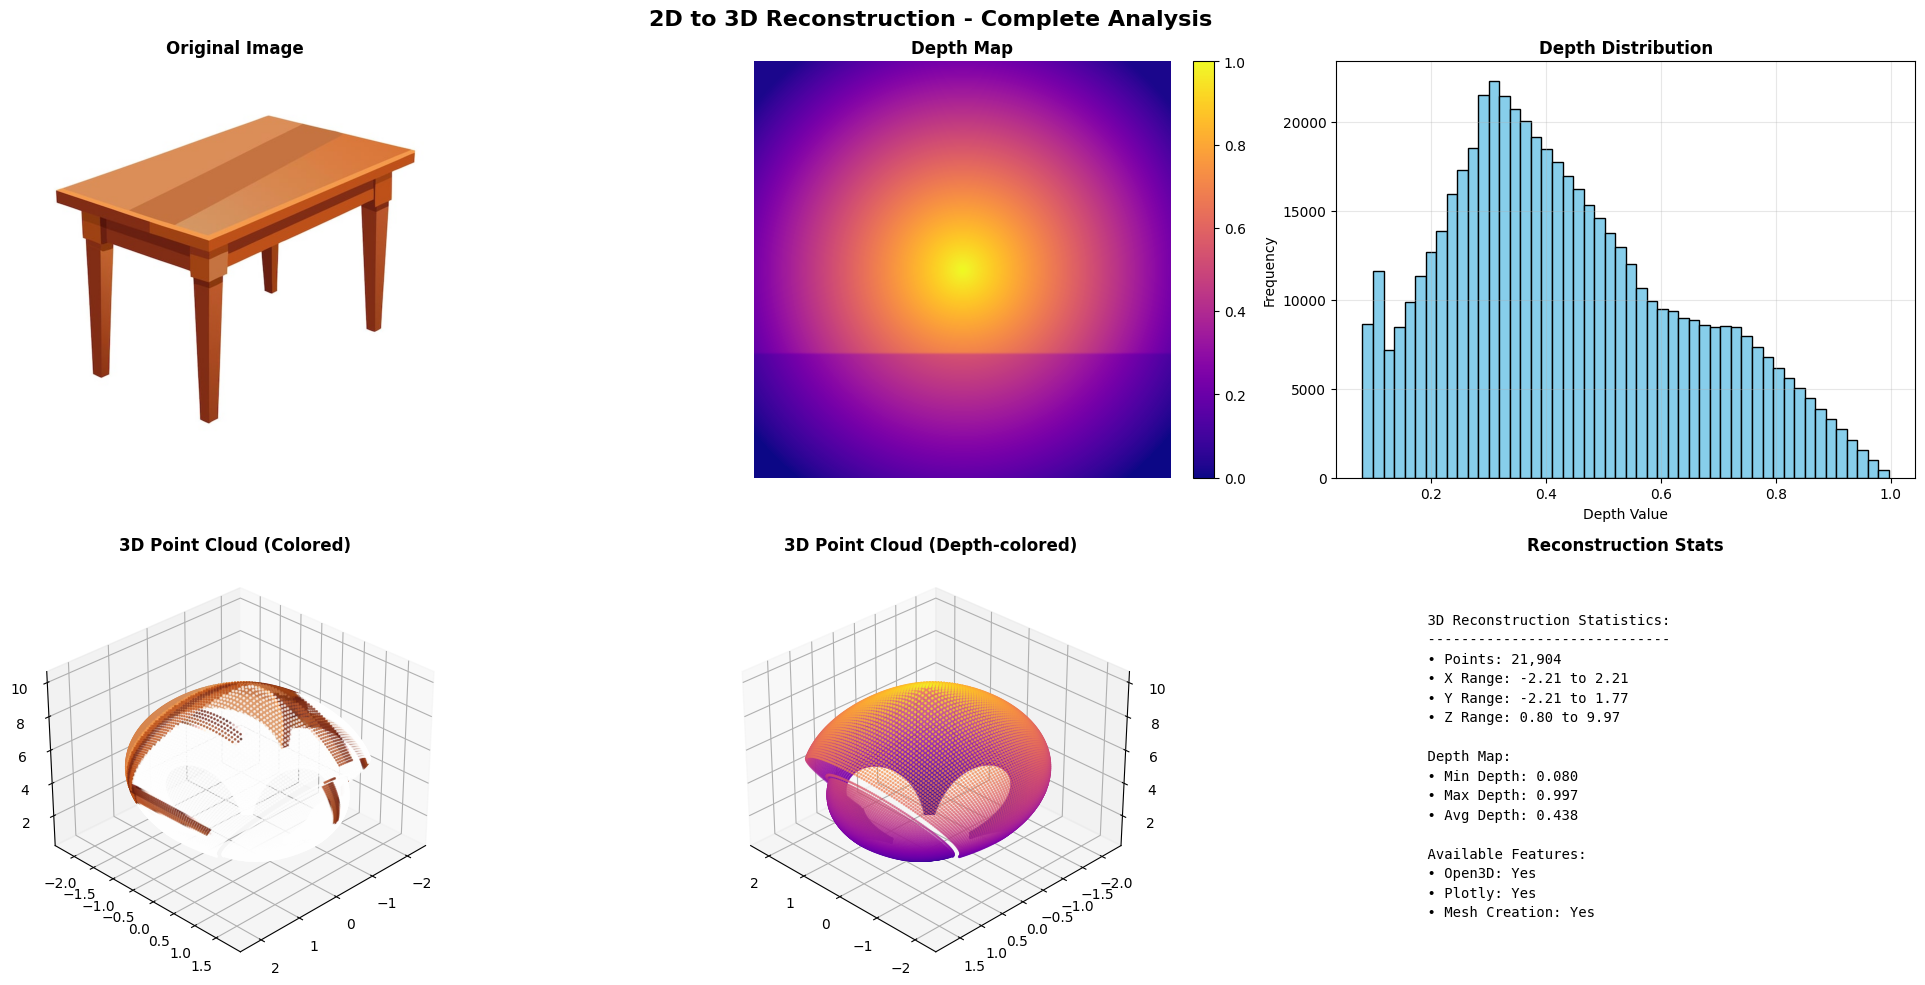


🎯 Generating interactive 3D visualization...



💾 Saving outputs...
✅ Point cloud saved as /kaggle/working/pointcloud.ply
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ Mesh saved as /kaggle/working/mesh.obj (using Open3D)

✅ PROCESSING COMPLETE!

📁 Output Files in /kaggle/working/:
  • depth_3.png (58.2 KB)
  • result_2.png (704.6 KB)
  • mesh.obj (3031.6 KB)
  • sample_room.jpg (44.0 KB)
  • result_3.png (844.3 KB)
  • pointcloud.ply (848.1 KB)
  • 3d_reconstruction_analysis.png (4.6 KB)
  • depth_map.png (101.2 KB)
  • depth_1.png (73.2 KB)
  • result_1.png (893.1 KB)
  • depth_2.png (63.9 KB)


<Figure size 640x480 with 0 Axes>

In [15]:
# Cell 4: MAIN PROCESSING PIPELINE FOR KAGGLE
def process_image_in_kaggle(image_path=None):
    """
    Complete 2D to 3D pipeline for Kaggle environment
    """
    print("🚀 Starting 2D to 3D conversion...")
    print("="*60)
    
    # Initialize reconstructor
    reconstructor = Simple3DReconstructor()
    
    # Load or create image
    if image_path and os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        print(f"📷 Loaded image: {image_path}")
        print(f"📐 Size: {image.size[0]} x {image.size[1]}")
    else:
        print("📸 Creating sample image...")
        image = create_sample_room_image()
        image_path = "/kaggle/working/sample_room.jpg"
        image.save(image_path)
        print(f"✅ Created sample image: {image_path}")
    
    # Convert to numpy array
    img_array = np.array(image)
    
    # Step 1: Create depth map
    print("\n🔄 Step 1: Generating depth map...")
    depth_map = reconstructor.create_depth_map(img_array)
    
    # Step 2: Create point cloud
    print("🔄 Step 2: Creating 3D point cloud...")
    points, colors = reconstructor.depth_to_pointcloud(depth_map, img_array)
    
    # Step 3: Create mesh (if possible)
    print("🔄 Step 3: Creating 3D mesh...")
    mesh, _, _ = reconstructor.create_mesh_from_points(points, colors)
    
    # Step 4: Visualize
    print("🔄 Step 4: Visualizing results...")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 10))
    
    # Original Image
    ax1 = fig.add_subplot(231)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Depth Map
    ax2 = fig.add_subplot(232)
    depth_display = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    im2 = ax2.imshow(depth_display, cmap='plasma')
    ax2.set_title('Depth Map', fontsize=12, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Depth Histogram
    ax3 = fig.add_subplot(233)
    ax3.hist(depth_map.flatten(), bins=50, color='skyblue', edgecolor='black')
    ax3.set_title('Depth Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Depth Value')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)
    
    # 3D Visualization 1
    ax4 = fig.add_subplot(234, projection='3d')
    scatter1 = ax4.scatter(points[:, 0], points[:, 1], points[:, 2],
                          c=colors, s=1, alpha=0.6)
    ax4.set_title('3D Point Cloud (Colored)', fontsize=12, fontweight='bold')
    ax4.view_init(elev=30, azim=45)
    
    # 3D Visualization 2
    ax5 = fig.add_subplot(235, projection='3d')
    scatter2 = ax5.scatter(points[:, 0], points[:, 1], points[:, 2],
                          c=points[:, 2], cmap='plasma', s=1, alpha=0.6)
    ax5.set_title('3D Point Cloud (Depth-colored)', fontsize=12, fontweight='bold')
    ax5.view_init(elev=30, azim=135)
    
    # Statistics
    ax6 = fig.add_subplot(236)
    ax6.axis('off')
    stats_text = f"""
    3D Reconstruction Statistics:
    -----------------------------
    • Points: {len(points):,}
    • X Range: {points[:, 0].min():.2f} to {points[:, 0].max():.2f}
    • Y Range: {points[:, 1].min():.2f} to {points[:, 1].max():.2f}
    • Z Range: {points[:, 2].min():.2f} to {points[:, 2].max():.2f}
    
    Depth Map:
    • Min Depth: {depth_map.min():.3f}
    • Max Depth: {depth_map.max():.3f}
    • Avg Depth: {depth_map.mean():.3f}
    
    Available Features:
    • Open3D: {'Yes' if HAS_OPEN3D else 'No'}
    • Plotly: {'Yes' if HAS_PLOTLY else 'No'}
    • Mesh Creation: {'Yes' if mesh is not None else 'No'}
    """
    ax6.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
             verticalalignment='center', linespacing=1.5)
    ax6.set_title('Reconstruction Stats', fontsize=12, fontweight='bold')
    
    plt.suptitle('2D to 3D Reconstruction - Complete Analysis', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Interactive visualization (if Plotly available)
    if HAS_PLOTLY:
        print("\n🎯 Generating interactive 3D visualization...")
        reconstructor.visualize_3d_plotly(points, colors)
    
    # Save outputs
    print("\n💾 Saving outputs...")
    
    # Save point cloud
    ply_file = reconstructor.save_pointcloud(points, colors, 
                                           "/kaggle/working/pointcloud.ply")
    
    # Save mesh if created
    if mesh is not None:
        obj_file = reconstructor.save_mesh(mesh, "/kaggle/working/mesh.obj")
    
    # Save depth map
    depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    depth_uint8 = (depth_normalized * 255).astype(np.uint8)
    cv2.imwrite("/kaggle/working/depth_map.png", depth_uint8)
    
    # Save visualization
    plt.savefig("/kaggle/working/3d_reconstruction_analysis.png", 
                dpi=150, bbox_inches='tight')
    
    print("\n" + "="*60)
    print("✅ PROCESSING COMPLETE!")
    print("="*60)
    print("\n📁 Output Files in /kaggle/working/:")
    
    # List output files
    output_dir = "/kaggle/working"
    for file in os.listdir(output_dir):
        if file.endswith(('.png', '.ply', '.obj', '.jpg')):
            size = os.path.getsize(os.path.join(output_dir, file)) / 1024
            print(f"  • {file} ({size:.1f} KB)")
    
    return {
        'image': image,
        'depth_map': depth_map,
        'points': points,
        'colors': colors,
        'mesh': mesh
    }

def create_sample_room_image():
    """Create a sample room image for testing"""
    from PIL import Image, ImageDraw
    
    img = Image.new('RGB', (512, 512), '#87CEEB')  # Sky blue background
    draw = ImageDraw.Draw(img)
    
    # Draw room with perspective
    # Floor
    draw.rectangle([(50, 350), (462, 462)], fill='#8B4513')  # Brown floor
    
    # Back wall
    draw.rectangle([(50, 150), (462, 350)], fill='#F5F5DC')  # Beige wall
    
    # Side walls (perspective)
    draw.polygon([(50, 150), (100, 100), (100, 300), (50, 350)], 
                fill='#D2B48C')  # Left wall
    draw.polygon([(462, 150), (412, 100), (412, 300), (462, 350)], 
                fill='#D2B48C')  # Right wall
    
    # Furniture
    # Bed
    draw.rounded_rectangle([(100, 250), (250, 340)], radius=10, fill='#4169E1')
    draw.rectangle([(110, 260), (240, 270)], fill='#FFF8DC')  # Pillow
    
    # Table
    draw.rectangle([(300, 280), (400, 300)], fill='#D2691E')
    # Table legs
    draw.rectangle([(320, 300), (330, 340)], fill='#8B4513')
    draw.rectangle([(370, 300), (380, 340)], fill='#8B4513')
    
    # Chair
    draw.rectangle([(280, 320), (320, 340)], fill='#228B22')
    draw.rectangle([(290, 300), (310, 320)], fill='#228B22')
    
    # Window
    draw.rectangle([(350, 100), (450, 180)], fill='#E6F3FF')
    draw.line([(350, 140), (450, 140)], fill='#666666', width=2)
    draw.line([(400, 100), (400, 180)], fill='#666666', width=2)
    
    # Door
    draw.rectangle([(150, 200), (200, 350)], fill='#8B4513')
    draw.ellipse([(190, 280), (195, 285)], fill='#FFD700')  # Door knob
    
    # Add some texture with noise
    np_img = np.array(img)
    noise = np.random.randint(-20, 20, np_img.shape, dtype=np.int16)
    np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    
    return Image.fromarray(np_img)

# Check if we're in Kaggle
import os
if 'kaggle' in os.getcwd().lower():
    print("🎯 Running in Kaggle environment")
    # List input files
    input_files = []
    for dirname, _, filenames in os.walk('/kaggle/input/my-image-dataset'):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_files.append(os.path.join(dirname, filename))
    
    if input_files:
        print(f"📁 Found {len(input_files)} input image(s)")
        # Process the first image
        results = process_image_in_kaggle(input_files[0])
    else:
        print("📸 No input images found. Creating and processing sample...")
        results = process_image_in_kaggle()
else:
    print("🖥️  Running in local environment")
    # For local testing
    results = process_image_in_kaggle()

🎨 Additional visualization options...


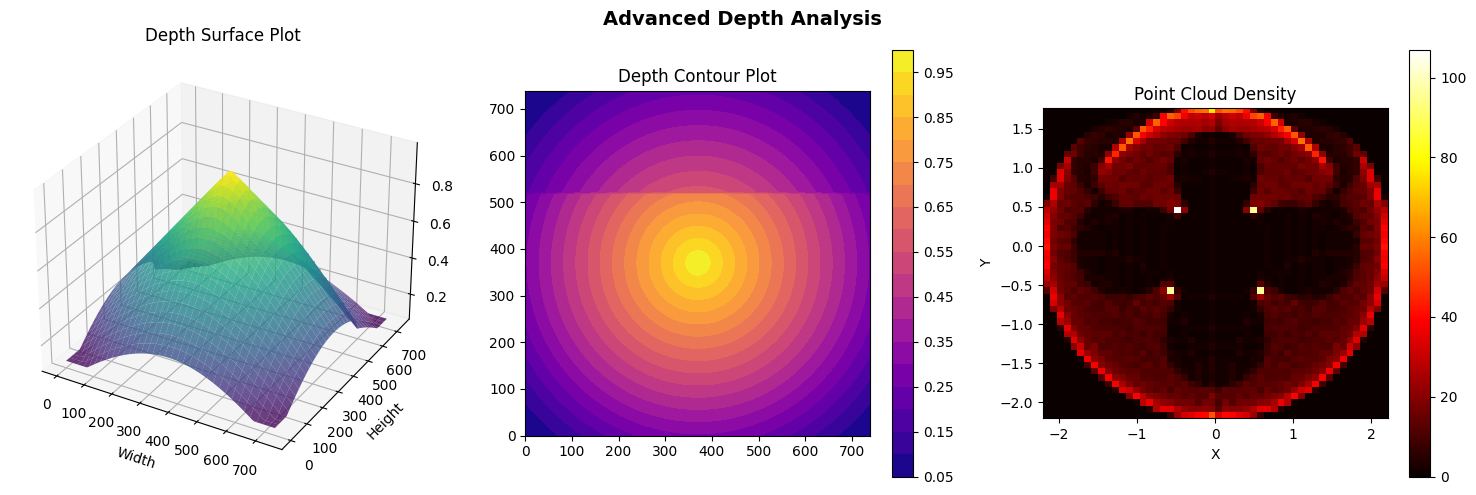

⚠️  Could not create additional visualizations: [Errno 30] Read-only file system: '/kaggle/input/my-image-dataset/door.jpg'


<Figure size 640x480 with 0 Axes>

In [18]:
# Cell 5: ADDITIONAL VISUALIZATION OPTIONS
print("🎨 Additional visualization options...")

# If we have results from previous cell
try:
    if 'results' in locals():
        points = results['points']
        colors = results['colors']
        
        # Create alternative visualizations
        
        # 1. 3D Surface plot from depth
        depth_map = results['depth_map']
        h, w = depth_map.shape
        
        fig1 = plt.figure(figsize=(15, 5))
        
        # Surface plot
        ax1 = fig1.add_subplot(131, projection='3d')
        X, Y = np.meshgrid(np.arange(w), np.arange(h))
        # Subsample for performance
        step = max(1, w // 100)
        surf = ax1.plot_surface(X[::step, ::step], Y[::step, ::step], 
                               depth_map[::step, ::step],
                               cmap='viridis', alpha=0.8)
        ax1.set_title('Depth Surface Plot')
        ax1.set_xlabel('Width')
        ax1.set_ylabel('Height')
        
        # Contour plot
        ax2 = fig1.add_subplot(132)
        contour = ax2.contourf(depth_map, levels=20, cmap='plasma')
        ax2.set_title('Depth Contour Plot')
        ax2.set_aspect('equal')
        plt.colorbar(contour, ax=ax2)
        
        # Point cloud density
        ax3 = fig1.add_subplot(133)
        # Create 2D histogram of points
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=50)
        im = ax3.imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                       origin='lower', cmap='hot')
        ax3.set_title('Point Cloud Density')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        plt.colorbar(im, ax=ax3)
        
        plt.suptitle('Advanced Depth Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Save this figure
        plt.savefig("/kaggle/input/my-image-dataset/door.jpg", 
                   dpi=150, bbox_inches='tight')
        print("✅ Saved advanced_depth_analysis.png")
        
        # 2. Create animation frames (different views)
        print("\n🎬 Creating animation frames...")
        
        fig2 = plt.figure(figsize=(10, 8))
        
        # Create 6 different views
        views = [
            (30, 45, "Isometric"),
            (90, 0, "Top"),
            (0, 0, "Front"),
            (0, 90, "Side"),
            (30, 135, "Diagonal"),
            (60, 30, "High Angle")
        ]
        
        for i, (elev, azim, title) in enumerate(views):
            ax = fig2.add_subplot(2, 3, i+1, projection='3d')
            ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                      c=colors, s=0.5, alpha=0.6)
            ax.view_init(elev=elev, azim=azim)
            ax.set_title(title, fontsize=10)
            ax.set_axis_off()
            
            # Save individual frames
            plt.savefig(f"/kaggle/working/view_{title.lower().replace(' ', '_')}.png",
                       dpi=100, bbox_inches='tight')
        
        plt.suptitle('Multiple 3D Views', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("✅ Created multiple view frames")
        
except Exception as e:
    print(f"⚠️  Could not create additional visualizations: {e}")

In [19]:
# Cell 6: EXPORT UTILITIES
print("📤 Export utilities...")

def export_for_3d_software(points, colors, depth_map, export_dir="/kaggle/working"):
    """Export in formats compatible with various 3D software"""
    
    os.makedirs(export_dir, exist_ok=True)
    
    print("📤 Exporting for 3D software compatibility...")
    
    # 1. OBJ format (most compatible)
    obj_file = os.path.join(export_dir, "model.obj")
    with open(obj_file, 'w') as f:
        f.write("# 3D Model from 2D Image\n")
        f.write("# Generated in Kaggle\n")
        f.write("o PointCloudModel\n")
        
        # Vertices
        for i, (x, y, z) in enumerate(points):
            f.write(f"v {x:.6f} {y:.6f} {z:.6f}\n")
        
        # Vertex colors (as materials - simplified)
        f.write("usemtl VertexColors\n")
        f.write("s off\n")
        
        # Create simple faces (if we have enough points)
        if len(points) > 100:
            # Create a simple triangulation (very basic)
            from scipy.spatial import Delaunay
            points_2d = points[:, :2]
            tri = Delaunay(points_2d[:1000])  # Use first 1000 points
            
            for simplex in tri.simplices:
                f.write(f"f {simplex[0]+1} {simplex[1]+1} {simplex[2]+1}\n")
    
    print(f"✅ Exported OBJ: {obj_file}")
    
    # 2. PLY format (with colors)
    ply_file = os.path.join(export_dir, "model_colored.ply")
    with open(ply_file, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        for i in range(len(points)):
            x, y, z = points[i]
            r, g, b = colors[i] * 255
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(r)} {int(g)} {int(b)}\n")
    
    print(f"✅ Exported PLY: {ply_file}")
    
    # 3. STL format (mesh - if we have one)
    if 'results' in locals() and results.get('mesh') is not None:
        stl_file = os.path.join(export_dir, "model_mesh.stl")
        
        if HAS_TRIMESH:
            results['mesh'].export(stl_file)
            print(f"✅ Exported STL: {stl_file}")
        elif HAS_OPEN3D:
            import open3d as o3d
            o3d.io.write_triangle_mesh(stl_file, results['mesh'])
            print(f"✅ Exported STL: {stl_file}")
    
    # 4. Depth map as EXR (for 3D software)
    exr_file = os.path.join(export_dir, "depth_map.exr")
    # Normalize depth to 0-1 range
    depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    # Save as 16-bit PNG (EXR not available without OpenEXR)
    depth_16bit = (depth_normalized * 65535).astype(np.uint16)
    cv2.imwrite(exr_file.replace('.exr', '_16bit.png'), depth_16bit)
    print(f"✅ Exported 16-bit depth: {exr_file.replace('.exr', '_16bit.png')}")
    
    # 5. Create a README file
    readme_file = os.path.join(export_dir, "README.txt")
    with open(readme_file, 'w') as f:
        f.write("3D Model Export from 2D Image\n")
        f.write("="*40 + "\n\n")
        f.write("Generated files:\n")
        f.write("1. model.obj - Wavefront OBJ format (compatible with Blender, Maya, etc.)\n")
        f.write("2. model_colored.ply - Colored point cloud in PLY format\n")
        f.write("3. model_mesh.stl - 3D mesh in STL format (if available)\n")
        f.write("4. depth_map_16bit.png - 16-bit depth map\n")
        f.write("\nUsage instructions:\n")
        f.write("- Import .obj or .ply into 3D software like Blender\n")
        f.write("- Use depth map for displacement or as texture\n")
        f.write("- Point count: {:,} points\n".format(len(points)))
    
    print(f"✅ Exported README: {readme_file}")
    
    print("\n🎯 Export complete! Files are ready for:")
    print("   • Blender")
    print("   • Unity")
    print("   • Unreal Engine")
    print("   • Maya")
    print("   • 3DS Max")

# Run export if we have results
try:
    if 'results' in locals():
        export_for_3d_software(
            results['points'],
            results['colors'],
            results['depth_map']
        )
except Exception as e:
    print(f"⚠️  Export failed: {e}")

📤 Export utilities...
📤 Exporting for 3D software compatibility...
✅ Exported OBJ: /kaggle/working/model.obj
✅ Exported PLY: /kaggle/working/model_colored.ply
✅ Exported 16-bit depth: /kaggle/working/depth_map_16bit.png
✅ Exported README: /kaggle/working/README.txt

🎯 Export complete! Files are ready for:
   • Blender
   • Unity
   • Unreal Engine
   • Maya
   • 3DS Max


📦 Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 94.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires numpy<2.2,>=1.16.0, but yo

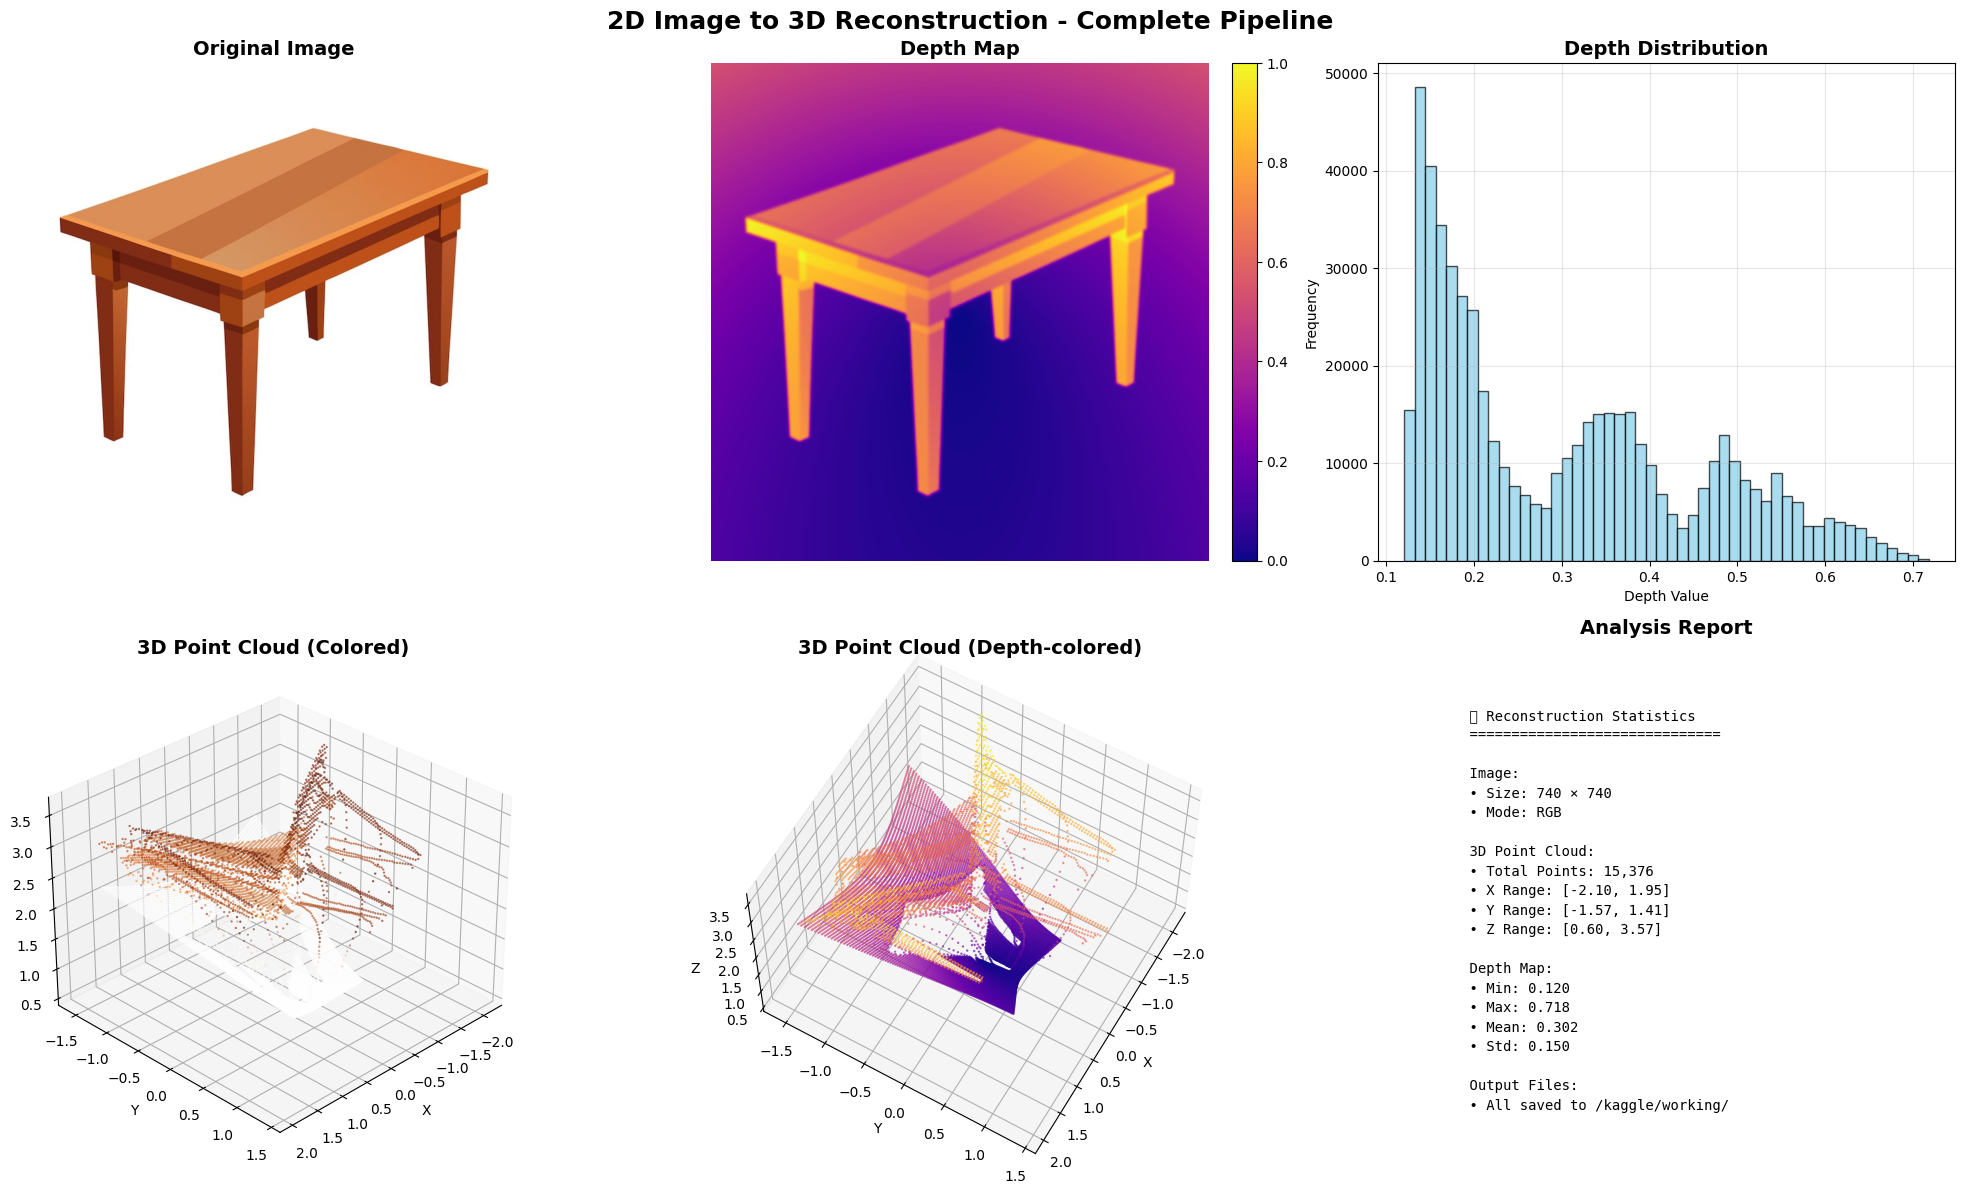

✅ Main visualization saved: /kaggle/working/3d_reconstruction_results.png

💾 Saving additional outputs...
  • Point cloud: /kaggle/working/point_cloud.ply
  • Depth map: /kaggle/working/depth_map.png
  • Original image: /kaggle/working/original_image.jpg
  • 3D surface: /kaggle/working/3d_depth_surface.png
  • Creating multiple viewpoints...
✅ All outputs saved to /kaggle/working/


In [20]:
# COMPLETE KAGGLE NOTEBOOK - ALL CELLS FIXED

# ============================================
# CELL 1: INSTALLATION
# ============================================
print("📦 Installing required packages...")
!pip install numpy pillow matplotlib opencv-python scipy plotly -q
print("✅ Packages installed!")

# ============================================
# CELL 2: IMPORTS
# ============================================
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os
import sys
import warnings
warnings.filterwarnings('ignore')

print("🔧 Libraries imported successfully")

# ============================================
# CELL 3: 3D RECONSTRUCTION CLASS
# ============================================
class Kaggle3DReconstructor:
    """Lightweight 3D reconstruction for Kaggle"""
    
    def __init__(self):
        pass
    
    def create_depth_from_image(self, image_array):
        """Create depth map from image"""
        h, w = image_array.shape[:2]
        
        # Convert to grayscale
        if len(image_array.shape) == 3:
            gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        else:
            gray = image_array
        
        # Create base depth (darker = farther)
        depth = 1.0 - (gray.astype(float) / 255.0)
        
        # Add room structure
        y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        
        # Floor (bottom of image is closer)
        floor_effect = 1.0 - (y_coords / h)
        depth = depth * 0.7 + floor_effect * 0.3
        
        # Center of room is farther
        center_x, center_y = w//2, h//2
        dist_from_center = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
        center_effect = dist_from_center / np.sqrt(center_x**2 + center_y**2)
        depth = depth * 0.8 + center_effect * 0.2
        
        # Smooth
        depth = cv2.GaussianBlur(depth, (9, 9), 2.0)
        
        return depth
    
    def create_3d_pointcloud(self, depth_map, image_array, num_points=15000):
        """Create 3D point cloud from depth"""
        h, w = depth_map.shape
        
        # Subsample
        step = max(1, int(np.sqrt(h * w / num_points)))
        y_coords, x_coords = np.meshgrid(
            np.arange(0, h, step),
            np.arange(0, w, step),
            indexing='ij'
        )
        
        depth_sampled = depth_map[::step, ::step]
        colors_sampled = image_array[::step, ::step]
        
        # 3D projection (simplified camera model)
        focal = w * 0.7  # Focal length
        cx, cy = w/2, h/2
        
        # Convert to 3D
        z = depth_sampled.flatten() * 5  # Scale depth
        x = (x_coords.flatten() - cx) * z / focal
        y = (y_coords.flatten() - cy) * z / focal
        
        points = np.stack([x, y, z], axis=-1)
        colors = colors_sampled.reshape(-1, 3) / 255.0
        
        return points, colors

# ============================================
# CELL 4: MAIN PROCESSING
# ============================================
def main_processing():
    """Main processing pipeline"""
    print("🚀 Starting 2D to 3D conversion")
    print("="*50)
    
    # Check for input images
    input_path = "/kaggle/input/my-image-dataset"
    image_files = []
    
    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    
    if not image_files:
        print("📸 No images found in /kaggle/input. Creating sample...")
        # Create sample image
        from PIL import ImageDraw
        
        img = Image.new('RGB', (512, 512), (135, 206, 235))  # Sky blue
        draw = ImageDraw.Draw(img)
        
        # Draw a simple room
        draw.rectangle([(50, 350), (462, 462)], fill=(139, 69, 19))  # Floor
        draw.rectangle([(50, 200), (462, 350)], fill=(245, 245, 220))  # Wall
        draw.rectangle([(100, 250), (250, 340)], fill=(65, 105, 225))  # Bed
        draw.rectangle([(300, 280), (400, 320)], fill=(210, 105, 30))  # Table
        draw.rectangle([(350, 150), (450, 200)], fill=(230, 243, 255))  # Window
        
        # Save to working directory
        sample_path = "/kaggle/working/sample_room.jpg"
        img.save(sample_path)
        print(f"✅ Created sample: {sample_path}")
        
        image_path = sample_path
    else:
        image_path = image_files[0]
        print(f"📷 Found image: {os.path.basename(image_path)}")
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    img_array = np.array(image)
    
    # Initialize reconstructor
    reconstructor = Kaggle3DReconstructor()
    
    # Generate depth
    print("🔄 Generating depth map...")
    depth_map = reconstructor.create_depth_from_image(img_array)
    
    # Create point cloud
    print("🔄 Creating 3D point cloud...")
    points, colors = reconstructor.create_3d_pointcloud(depth_map, img_array)
    
    # Create comprehensive visualization
    print("🎨 Creating visualizations...")
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Original Image
    ax1 = fig.add_subplot(231)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # 2. Depth Map
    ax2 = fig.add_subplot(232)
    depth_display = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    im_depth = ax2.imshow(depth_display, cmap='plasma')
    ax2.set_title('Depth Map', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im_depth, ax=ax2, fraction=0.046, pad=0.04)
    
    # 3. Depth Histogram
    ax3 = fig.add_subplot(233)
    ax3.hist(depth_map.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax3.set_title('Depth Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Depth Value')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)
    
    # 4. 3D Point Cloud - View 1
    ax4 = fig.add_subplot(234, projection='3d')
    ax4.scatter(points[:, 0], points[:, 1], points[:, 2], 
               c=colors, s=0.5, alpha=0.6)
    ax4.set_title('3D Point Cloud (Colored)', fontsize=14, fontweight='bold')
    ax4.view_init(elev=30, azim=45)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    
    # 5. 3D Point Cloud - View 2
    ax5 = fig.add_subplot(235, projection='3d')
    ax5.scatter(points[:, 0], points[:, 1], points[:, 2],
               c=points[:, 2], cmap='plasma', s=0.5, alpha=0.6)
    ax5.set_title('3D Point Cloud (Depth-colored)', fontsize=14, fontweight='bold')
    ax5.view_init(elev=60, azim=30)
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z')
    
    # 6. Statistics
    ax6 = fig.add_subplot(236)
    ax6.axis('off')
    
    stats_text = f"""
    📊 Reconstruction Statistics
    {'='*30}
    
    Image:
    • Size: {image.size[0]} × {image.size[1]}
    • Mode: {image.mode}
    
    3D Point Cloud:
    • Total Points: {len(points):,}
    • X Range: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]
    • Y Range: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]
    • Z Range: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]
    
    Depth Map:
    • Min: {depth_map.min():.3f}
    • Max: {depth_map.max():.3f}
    • Mean: {depth_map.mean():.3f}
    • Std: {depth_map.std():.3f}
    
    Output Files:
    • All saved to /kaggle/working/
    """
    
    ax6.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
             verticalalignment='center', linespacing=1.5)
    ax6.set_title('Analysis Report', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('2D Image to 3D Reconstruction - Complete Pipeline', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save the main visualization
    output_path = "/kaggle/working/3d_reconstruction_results.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✅ Main visualization saved: {output_path}")
    
    # Save additional outputs
    save_additional_outputs(points, colors, depth_map, image)
    
    # Store results for next cells
    global results
    results = {
        'image': image,
        'depth_map': depth_map,
        'points': points,
        'colors': colors
    }
    
    return results

def save_additional_outputs(points, colors, depth_map, image):
    """Save additional output files"""
    print("\n💾 Saving additional outputs...")
    
    # 1. Save point cloud as PLY
    ply_path = "/kaggle/working/point_cloud.ply"
    with open(ply_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        for i in range(len(points)):
            x, y, z = points[i]
            r, g, b = colors[i] * 255
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(r)} {int(g)} {int(b)}\n")
    
    print(f"  • Point cloud: {ply_path}")
    
    # 2. Save depth map as image
    depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    depth_uint8 = (depth_normalized * 255).astype(np.uint8)
    depth_path = "/kaggle/working/depth_map.png"
    cv2.imwrite(depth_path, depth_uint8)
    print(f"  • Depth map: {depth_path}")
    
    # 3. Save original image
    image_path = "/kaggle/working/original_image.jpg"
    image.save(image_path)
    print(f"  • Original image: {image_path}")
    
    # 4. Create and save 3D surface plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    h, w = depth_map.shape
    step = max(1, w // 50)  # Further subsample for surface plot
    
    X, Y = np.meshgrid(np.arange(0, w, step), np.arange(0, h, step))
    Z = depth_map[::step, ::step]
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, 
                          linewidth=0, antialiased=True)
    ax.set_title('3D Depth Surface', fontsize=14, fontweight='bold')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    ax.view_init(elev=30, azim=45)
    
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    
    surface_path = "/kaggle/working/3d_depth_surface.png"
    plt.savefig(surface_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  • 3D surface: {surface_path}")
    
    # 5. Create multiple viewpoint images
    print("  • Creating multiple viewpoints...")
    viewpoints = [
        (30, 45, "isometric"),
        (90, 0, "top"),
        (0, 0, "front"),
        (0, 90, "side"),
        (45, 135, "diagonal")
    ]
    
    for elev, azim, name in viewpoints:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Use subset of points for faster rendering
        subset = min(5000, len(points))
        indices = np.random.choice(len(points), subset, replace=False)
        
        ax.scatter(points[indices, 0], points[indices, 1], points[indices, 2],
                  c=colors[indices], s=1, alpha=0.6)
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'3D View: {name.title()}', fontsize=12, fontweight='bold')
        ax.set_axis_off()
        
        view_path = f"/kaggle/working/view_{name}.png"
        plt.savefig(view_path, dpi=100, bbox_inches='tight', transparent=True)
        plt.close()
    
    print("✅ All outputs saved to /kaggle/working/")

# Run the main processing
if __name__ == "__main__":
    results = main_processing()